<a id="contents"></a>

# Introduction
* This notebook contains an analysis and modeling of the "Rossmann Store Sales" dataset from kaggle: www.kaggle.com/c/rossmann-store-sales.
* The goal of the competition is to train a model that predicts future sales of six weeks in advance, with the lowest Root Mean Square Percentage Error (RMSPE).
* This is a two-day project I did with two of my teammates, [Amit Sarid](https://github.com/amitsarid) and [Ido Berlin](https://github.com/IdoBerlin).
* The purpose of this project for us was to experiment with time-series data and with the Facebook Prophet tool.

#### The notebook is divided into the following parts:
* [Notebook preparation](#preperation)
    * [Imports](#imports)
    * [Functions](#functions)
* [Data QA, exploration and cleaning](#data_qa)
* [Feature engineering](#feature_engineering)
    * [Store features](#store_features)
    * [Time features](#time_features)
    * [Previous sales features](#previous_sales_features)
    * [Facebook Prophet features](#prophet)
* [Feature analysis](#feature_analysis)
* [Modeling](#regression)
* [Prediction the test and make submission](#predict)

#### The prediction that we submitted to kaggle got RMSPE score of 0.13223, which is really high compared to other competitors.

<a id="preperation"></a>
# Notebook preparation
[Back to contents](#contents)

<a id="imports"></a>
## Imports
[Back to contents](#contents)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, norm, probplot, boxcox
from statsmodels.distributions.empirical_distribution import ECDF
import random
from pandas_profiling import ProfileReport
from datetime import datetime
from tqdm.notebook import tqdm
import pickle

# Visualization
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
from pathlib import Path

# Machine learning
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import HuberRegressor, BayesianRidge, ElasticNet, LinearRegression, PassiveAggressiveRegressor, RANSACRegressor, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer

# Prophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import shap

<a id="functions"></a>
## Functions
[Back to contents](#contents)

In [2]:
def style_plot(fig):
    fig.set_size_inches(10, 5)
    plt.xticks(rotation=70)
    plt.show()

def get_bar_plot(df, column, CLASS_LABEL, q=20):

    df = df[~pd.isna(df[column])]
    binsDf = pd.DataFrame(pd.qcut(df[column], q=q, duplicates='drop').apply(lambda x: x.right))
    binsDf[CLASS_LABEL] = list(df[CLASS_LABEL])

    data = binsDf.groupby(column).agg({CLASS_LABEL: 'mean', column: 'count'})
    
    if len(data) <= 1: # There is not enough data for a graph
        return
    
    data.columns = ['mean','count']

    sns.barplot(data.index, data['mean'])
    fig = plt.gcf()
    style_plot(fig)
    
def get_distribution_and_QQ_plot_of_a_column(columnName, column):
    fig = plt.figure(figsize=(12,4))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(column)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(column, fit=norm)
    fig1.set_title('Distribution (mu = {:.2f} and sigma = {:.2f})'.format(mu, sigma), loc='center')
    fig1.set_xlabel(columnName)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(column, plot=fig2)
    fig2.set_title('Probability Plot (skewness: {:.6f} and kurtosis: {:.6f})'.\
                   format(column.skew(), column.kurt()), loc='center')

    plt.tight_layout()
    plt.show()
    
def parse_competition_date(row):
    if pd.isna(row[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']]).any():
        return None
    return pd.to_datetime('01-' + str(int(row['CompetitionOpenSinceMonth'])) + '-' + str(int(row['CompetitionOpenSinceYear'])), dayfirst=True)

def parse_promo2_date(row):
    if pd.isna(row[['Promo2SinceWeek', 'Promo2SinceYear']]).any():
        return None
    year = pd.to_datetime(str(int(row['Promo2SinceYear'])), format='%Y')
    day_of_year = pd.to_timedelta(str(row['Promo2SinceWeek'] * 7) + ' days')
    return year + day_of_year

def add_days_since_and_to_holiday(df):
    df = df.copy()
    df = df.sort_values('Date', ascending=True).copy()
    df['StateHolidayDate'] = df[df['StateHoliday']!='0']['Date']
    df['PreviousHoliday'] = df['StateHolidayDate'].fillna(method='ffill')
    df['NextHoliday']     = df['StateHolidayDate'].fillna(method='bfill')
    df['DaysSincePreviousHoliday'] = (pd.to_datetime(df['Date'])        - pd.to_datetime(df['PreviousHoliday'])).dt.days
    df['DaysToNextHoliday']        = (pd.to_datetime(df['NextHoliday']) - pd.to_datetime(df['Date'])).dt.days
    df.drop(['StateHolidayDate', 'PreviousHoliday', 'NextHoliday'], axis=1, inplace=True)
    return df.sort_index()
    
def nan_percentage(self):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    helper = self.isnull().sum().sort_values(ascending = False)
    total = helper[helper > 0]
    percent = round(total/len(self)*100,2)
    result = pd.concat([total, percent], axis=1, keys=['NaNs','Percent'])
    result['Percent'] = result['Percent'].astype(str) + ' %'
    return result.T

pd.DataFrame.nan_percentage = nan_percentage
pd.Series.nan_percentage = nan_percentage

def rmspe(y_true, y_pred):
    
    tempDf = pd.DataFrame({'true':y_true, 'pred':y_pred})
    tempDf = tempDf.loc[tempDf['true']>0]
    
    y_true = tempDf['true'].values
    y_pred = tempDf['pred'].values
       
    error = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

    return error

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

def plot_feature_importance(X_test, fit): 

    assert hasattr(fit, 'feature_importances_'), 'No feature importance attribute in the fit'
        
    impDf = pd.DataFrame(list(zip(X_test.columns, fit.feature_importances_)), columns=['feature', 'imp'])\
    .sort_values('imp', ascending=False)

    sns.barplot(x='imp', y='feature', data=impDf.iloc[:25])
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    plt.title('Feature importance')
    plt.show()
    
def prepare_df_for_model(df, features, CLASS_LABEL=None, toScale=False, scaler=None):
    
    currDf = df.copy()
    
    for feature in features:
        currDf[feature] = currDf[feature].astype(float)
    
    currDf = currDf[features]
        
    for column in currDf.columns:
        maxValue = currDf[column][(currDf[column] != np.inf) & (currDf[column] != -np.inf)].max()
        currDf[column].replace([np.inf, -np.inf], maxValue, inplace=True)
        
    currDf[features] = currDf[features].fillna(currDf[features].quantile(0.5))
    
    if toScale:
        
        if scaler == None:
            currScaler = StandardScaler()
            currScaler = currScaler.fit(currDf)
        else:
            currScaler = scaler
            
        currDf_scaled = currScaler.transform(currDf)
        currDf = pd.DataFrame(currDf_scaled, columns=currDf.columns)
        
    if CLASS_LABEL:
        currDf[CLASS_LABEL] = df[CLASS_LABEL]

    if toScale & (scaler == None):
        return currDf, currScaler
    else:
        return currDf
    
    
def get_shap_values(ModFit, X):
    
    if hasattr(ModFit, 'best_estimator_'):
        mybooster = ModFit.best_estimator_.get_booster().copy()
    else:
        mybooster = ModFit.get_booster().copy()

    model_bytearray = mybooster.save_raw()[4:]
    
    def myfun(self=None):
        return model_bytearray

    mybooster.save_raw = myfun

    explainer = shap.TreeExplainer(mybooster)
    expected_value = explainer.expected_value
    shap_values = explainer.shap_values(X)
    
    return mybooster, explainer, expected_value, shap_values


def get_shap_summary_plot(X, explainer, expected_value, shap_values, toShow=True, toSave=False, fileName=None):
    
    if toShow:
        shap.summary_plot(shap_values, X, show=True)
    if toSave:
        if fileName is None:
            fileName = 'shap_summary_plot.png'
        shap.summary_plot(shap_values, X, show=False)
        plt.savefig(fileName, pad_inches=0.2, bbox_inches='tight')
        plt.clf()

<a id="data_qa"></a>
# Data QA, exploration and cleaning
[Back to contents](#contents)

#### Conclusions based on the data exploration:
* There is data on 1115 unique stores.
* The train df contains data from:  2013_01_01-2015_07_31
* The test df contains data from: 2015_08_01-2015_09_17
* From the 01/07/2014-31/12/2014 there is data only about 935 stores, instread of 1115.
* In the test there are only 856 stores, all of them exist in the train.
* When Open == 0, Sales also equals to 0.
* There is seasonality of a year, of 1 week and of 2 weeks.
* There are a few stores that are closed for a long period at the begining of the data. We decided to filter all the rows of the stores from before their first open day.

In [3]:
TARGET_COLUMN = 'Sales'

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
store_df = pd.read_csv('store.csv')

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
train_df['StateHoliday'] = train_df['StateHoliday'].astype(str)
test_df['StateHoliday'] = test_df['StateHoliday'].astype(str)

In [5]:
for df, name in [(train_df, 'Train'), (test_df, 'Test'), (store_df, 'Stores')]:
    
    print(f'{name} df:')
    display(df.head(5))
    print(f"Shape: {df.shape}")
    
    profile = ProfileReport(df=df, title=f"Profile Report of {name} Dataset", explorative=True)
    profile.to_file(Path(f"profile_report_{name.lower()}.html"))

Train df:


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Shape: (1017209, 9)
Test df:


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


Shape: (41088, 8)
Stores df:


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Shape: (1115, 10)


In [6]:
y_train = train_df[TARGET_COLUMN]

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


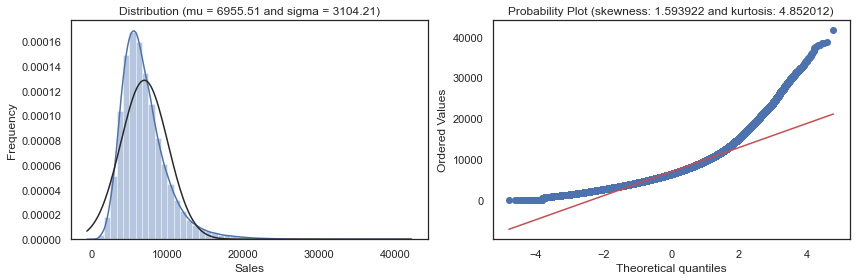

In [7]:
get_distribution_and_QQ_plot_of_a_column(TARGET_COLUMN, y_train.loc[train_df['Open']==1])

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


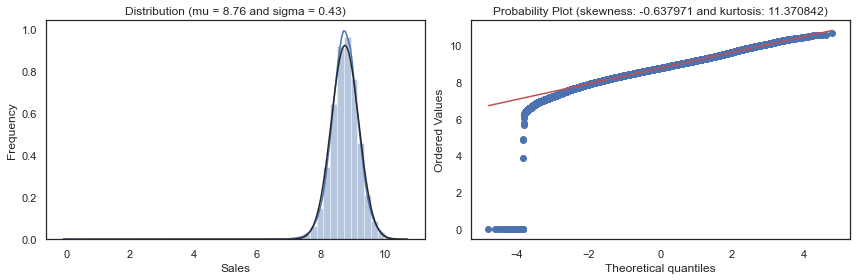

In [8]:
y_train_orig = y_train.copy()
y_train = np.log1p(y_train_orig)
get_distribution_and_QQ_plot_of_a_column(TARGET_COLUMN, y_train.loc[train_df['Open']==1])

In [9]:
TARGET_COLUMN = f'{TARGET_COLUMN}_log'
train_df[TARGET_COLUMN] = y_train

In [10]:
train_df['datetime'] = pd.to_datetime(train_df['Date'])
train_df['SalePerCustomer'] = train_df['Sales'] / train_df['Customers']

test_df['datetime'] = pd.to_datetime(test_df['Date'])

In [11]:
print('Time range of train:', train_df['Date'].min(), train_df['Date'].max())
print('Time range of test:',test_df['Date'].min(), test_df['Date'].max())

Time range of train: 2013-01-01 2015-07-31
Time range of test: 2015-08-01 2015-09-17


In [12]:
print('Amout of stores in test and not in train:', len(set(test_df['Store']) - set(train_df['Store'])))
print('Amout of stores in train and not in test:', len(set(train_df['Store']) - set(test_df['Store'])))
print('Amout of stores both in train and in test:', len(set(train_df['Store']) & set(test_df['Store'])))

Amout of stores in test and not in train: 0
Amout of stores in train and not in test: 259
Amout of stores both in train and in test: 856


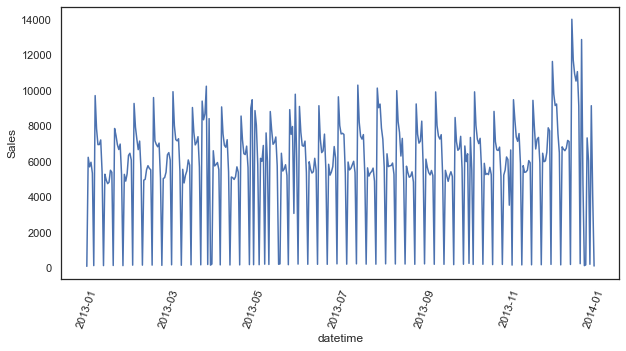

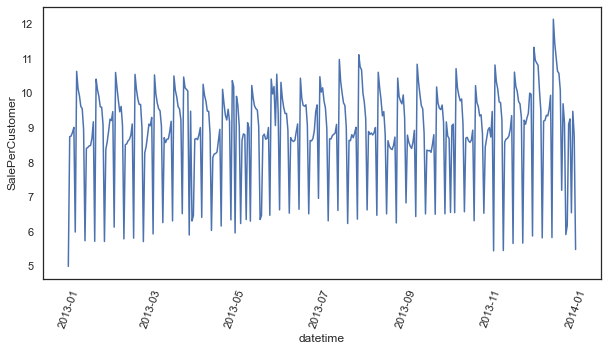

In [13]:
for y_axis in ['Sales','SalePerCustomer']:
    # Zoom in on 1 year
    sns.lineplot(data=train_df[train_df['Date']<='2014-01-01']\
                     .groupby(['datetime'], as_index=False)\
                     .agg({y_axis:'mean'}), 
                 x='datetime', 
                 y=y_axis)
    fig = plt.gcf()
    style_plot(fig)

In [14]:
# deeper look at the data shows that the seasonality is of 1 and 2 weeks.
train_df[train_df['Date']<='2013-04-01']\
         .groupby(['datetime','DayOfWeek'], as_index=False)\
         .agg({TARGET_COLUMN:'mean'})[0:50]

,datetime,DayOfWeek,Sales_log
0,2013-01-01,2,0.129461
1,2013-01-02,3,8.635560
2,2013-01-03,4,8.535310
3,2013-01-04,5,8.580564
4,2013-01-05,6,8.415379
5,2013-01-06,7,0.148680
6,2013-01-07,1,9.049211
7,2013-01-08,2,8.834045
8,2013-01-09,3,8.713095
9,2013-01-10,4,8.715249


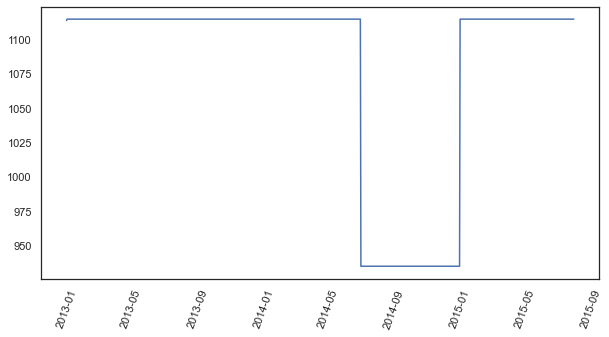

In [15]:
plt.plot(train_df.groupby('datetime')['Store'].count())
fig = plt.gcf()
style_plot(fig)

In [16]:
train_df.loc[train_df['Open']==1].groupby('Store')["Date"].transform('min').value_counts()

2013-01-02    825829
2013-01-01     15712
2013-07-05      1388
2013-01-17       763
2013-04-12       700
Name: Date, dtype: int64

In [17]:
train_df.loc[train_df['Open']==0].groupby('Store')[TARGET_COLUMN].mean().value_counts()

0.0    1105
Name: Sales_log, dtype: int64

<a id="feature_engineering"></a>
# Feature engineering
[Back to contents](#contents)

In [18]:
features = ['Open', 'SchoolHoliday', 'DayOfWeek' ,'Promo']

<a id="store_features"></a>
## Store features
[Back to contents](#contents)

In [19]:
# create store dataframe additional columns

store_df['CompetionOpenDate'] = store_df.apply(parse_competition_date, axis=1)
store_df['Promo2StartDate'] = store_df.apply(parse_promo2_date, axis=1)
store_df['AssortmentInt'] = store_df['Assortment'].map({'a': 0, 'b':1, 'c': 2})
store_df['PromoIntervalOffset'] = store_df['PromoInterval'].map({'Jan,Apr,Jul,Oct': 0, 'Feb,May,Aug,Nov': 1, 'Mar,Jun,Sept,Dec': 2})

features.extend(['AssortmentInt', 'PromoIntervalOffset'])

In [20]:
# join between train and test to the store df
train_store_df = train_df.join(store_df.set_index('Store'), on='Store')
test_store_df = test_df.join(store_df.set_index('Store'), on='Store')

train_store_df['is_train'] = True
test_store_df['is_train'] = False

# concat train and test so all feature enginnering will be done together
store_open_date_df = train_df.loc[train_df['Open']==1].groupby('Store')['Date'].agg('min').to_frame()
store_open_date_df = store_open_date_df.rename(columns={'Date':'StoreOpen'})
store_open_date_df['StoreOpen'] = pd.to_datetime(store_open_date_df['StoreOpen'])

full_df = pd.concat([train_store_df, test_store_df]).reset_index(drop=True)
full_df = full_df.join(store_open_date_df, on='Store')

<a id="time_features"></a>
## Time features
[Back to contents](#contents)

In [21]:
# compute the days from open
full_df['DaysFromOpen'] = (full_df['datetime'] - full_df['StoreOpen']).dt.days

# remove rows from before (over one day) store first opened
full_df = full_df.loc[full_df['DaysFromOpen']>=-1]
full_df = full_df.copy()

features.extend(['DaysFromOpen'])

In [22]:
# create time since competition store opened and time since promo2 started
full_df['DaysFromCompetitionOpen'] = (full_df['datetime'] - full_df['CompetionOpenDate']).dt.days
full_df['DaysFromPromo2Start'] = (full_df['datetime'] - full_df['Promo2StartDate']).dt.days
full_df.loc[full_df['DaysFromCompetitionOpen']<0, 'DaysFromCompetitionOpen'] = -1
full_df.loc[full_df['DaysFromPromo2Start']<0, 'DaysFromPromo2Start'] = -1

# create time since promo2 interval
full_df['MonthSincePromo2Interval'] = (full_df['datetime'].dt.month - full_df['PromoIntervalOffset']).mod(3)
full_df.loc[full_df['DaysFromPromo2Start']<0, 'MonthSincePromo2Interval'] = None

features.extend(['DaysFromCompetitionOpen', 'DaysFromPromo2Start', 'MonthSincePromo2Interval'])

In [23]:
# add days since and to holiday
full_df = add_days_since_and_to_holiday(full_df)

In [24]:
# add more types of "day of week" features
full_df['DayOfTwoWeeks'] = (np.mod((full_df['datetime'] - pd.to_datetime('24-12-2012')).dt.days, 14))
full_df['DayOfTwoWeeks_fixed_1'] = full_df['DayOfTwoWeeks'].apply(lambda x: np.mod(x-0.5 if x>=8 else x,7))
full_df['DayOfTwoWeeks_fixed_2'] = full_df['DayOfTwoWeeks'].apply(lambda x: 13.5 if x==13 else np.mod(x+7,14))

features.extend(['DayOfTwoWeeks', 'DayOfTwoWeeks_fixed_1', 'DayOfTwoWeeks_fixed_2'])

In [25]:
# convert StateHoliday to binary features
categoricalFeatures = ['StateHoliday'] 

fullDfGetDummies = pd.get_dummies(full_df[categoricalFeatures].astype(str))
full_df = full_df.merge(fullDfGetDummies, left_index=True, right_index=True,how='left')

features.extend(list(fullDfGetDummies.columns))

<a id="previous_sales_features"></a>
## Previous sales features
[Back to contents](#contents)

In [26]:
# add features of previos sales per different groups 
full_df.sort_values(by='Date', inplace=True)
train_df = full_df.loc[full_df['is_train']].copy()
test_df = full_df.loc[~full_df['is_train']].copy()

for columnToAgg in ['Sales', 'Customers']:
    for colAgg1 in ['Store', 'StoreType']:
        for colAgg2 in tqdm(['DayOfWeek','DayOfTwoWeeks','DayOfTwoWeeks_fixed_1','DayOfTwoWeeks_fixed_2']):
            
            columnsToGroup = [colAgg1, colAgg2]

            columnName = f'mean_{columnToAgg}_per_{"_".join(columnsToGroup)}'
            train_df_sum = train_df.groupby(by=columnsToGroup)[columnToAgg].expanding(2).sum()
            train_df_count = train_df.groupby(by=columnsToGroup)[columnToAgg].expanding(2).count()
            train_df_sum.index = [i[-1] for i in train_df_sum.index]
            train_df_count.index = [i[-1] for i in train_df_count.index]
            train_df[columnName] = (train_df_sum - train_df[columnToAgg]) / (train_df_count - 1)
            
            groupedByDf = train_df.groupby(columnsToGroup).agg({columnToAgg:'mean'})
            groupedByDict = {k:v for k,v in zip(groupedByDf.index, groupedByDf[columnToAgg].values)}
            test_df[columnName] = test_df.apply(lambda row: groupedByDict.get((row[colAgg1], row[colAgg2])),axis=1)
            
            features.append(columnName)
            
full_df = pd.concat([train_df, test_df]).sort_values(by='Date').reset_index(drop=True)

<a id="prophet"></a>
## Facebook Prophet features
[Back to contents](#contents)

In [27]:
full_df['ds'] = full_df['datetime']
full_df['y'] = full_df[TARGET_COLUMN]

random_store = random.choice(full_df['Store'].unique())
print(f"random_store = {random_store}")
prophet_df = full_df.loc[(full_df['Store']==random_store) & \
                         (full_df['is_train']) & \
                         (full_df['Open'] == 1)][['ds','y']]

random_store = 197


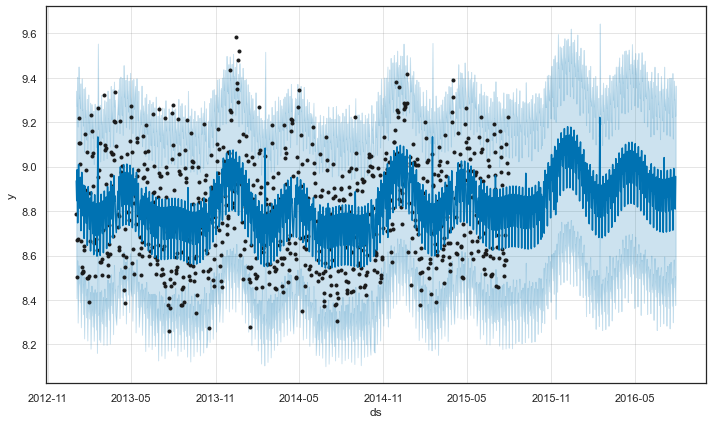

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


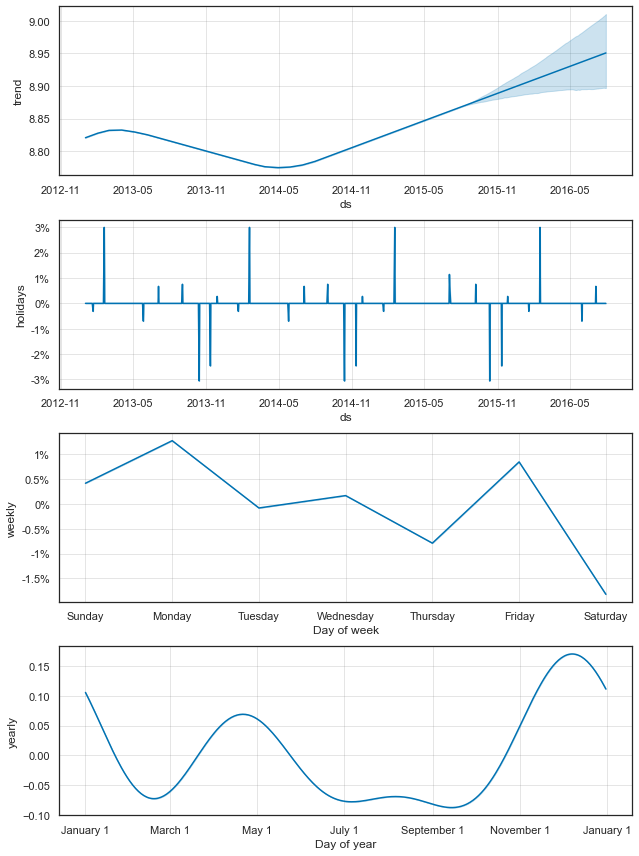

In [28]:
prophet = Prophet(daily_seasonality=False,
                  yearly_seasonality=False,
                  interval_width = 0.95, 
                  holidays=None,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0)
prophet.add_seasonality(name='yearly',
                        period=365.25,
                        fourier_order=3,
                        prior_scale=10,
                        mode='additive')
prophet.add_country_holidays(country_name='US')
prophet.fit(prophet_df)
future = prophet.make_future_dataframe(periods=52*7, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
# a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

fig2 = prophet.plot_components(forecast)
plt.show()

In [29]:
for store in tqdm(full_df['Store'].unique()):
    prophet_df = full_df.loc[(full_df['Store']==store) & \
                         (full_df['is_train']) & \
                         (full_df['Open'] == 1)][['ds','y']]
    
    prophet = Prophet(daily_seasonality=False,
                      yearly_seasonality=False,
                      interval_width = 0.95, 
                      holidays=None,
                      seasonality_mode='multiplicative',
                      seasonality_prior_scale=10,
                      holidays_prior_scale=10,
                      changepoint_prior_scale=.05,
                      mcmc_samples=0)
    prophet.add_seasonality(name='yearly',
                            period=365.25,
                            fourier_order=3,
                            prior_scale=10,
                            mode='additive')
    prophet.add_country_holidays(country_name='US')
    prophet.fit(prophet_df)
    future = prophet.make_future_dataframe(periods=52*7, freq='D')
    forecast = prophet.predict(future)

    forecastDict = {(store, date): yhat for date,yhat in zip(forecast['ds'],forecast['yhat'])}
    full_df.loc[full_df['Store']==store, 'prophet_forecast'] = full_df.loc[full_df['Store']==store]\
        .apply(lambda row: forecastDict.get((store, row['datetime'])) ,axis=1)

In [30]:
features.append('prophet_forecast')

<a id="feature_analysis"></a>
# Feature analysis
[Back to contents](#contents)

In [34]:
full_df.nan_percentage()

,Id,MonthSincePromo2Interval,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Promo2StartDate,PromoIntervalOffset,DaysFromPromo2Start,DaysFromCompetitionOpen,CompetitionOpenSinceMonth,...,CompetitionDistance,mean_Customers_per_StoreType_DayOfTwoWeeks_fixed_2,mean_Customers_per_StoreType_DayOfTwoWeeks,mean_Sales_per_StoreType_DayOfTwoWeeks,mean_Sales_per_StoreType_DayOfTwoWeeks_fixed_2,mean_Sales_per_StoreType_DayOfTwoWeeks_fixed_1,mean_Customers_per_StoreType_DayOfTwoWeeks_fixed_1,mean_Customers_per_StoreType_DayOfWeek,mean_Sales_per_StoreType_DayOfWeek,Open
NaNs,1016726,595871,524795,524795,524795,524795,524795,524795,338549,338549,...,2738,56,56,56,56,52,52,28,28,11
Percent,96.12 %,56.33 %,49.61 %,49.61 %,49.61 %,49.61 %,49.61 %,49.61 %,32.0 %,32.0 %,...,0.26 %,0.01 %,0.01 %,0.01 %,0.01 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %


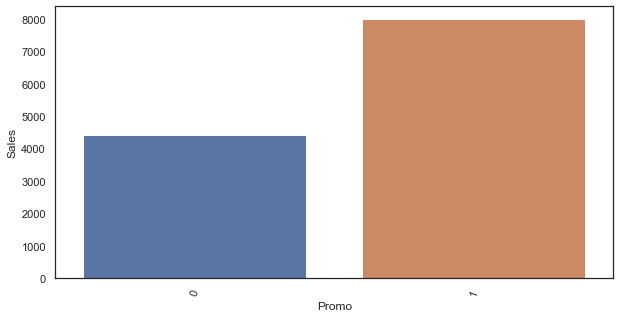

In [35]:
data = full_df.groupby('Promo', as_index=False).agg({'Sales':'mean'})

sns.barplot(data=data, x='Promo', y='Sales')
fig = plt.gcf()
style_plot(fig)

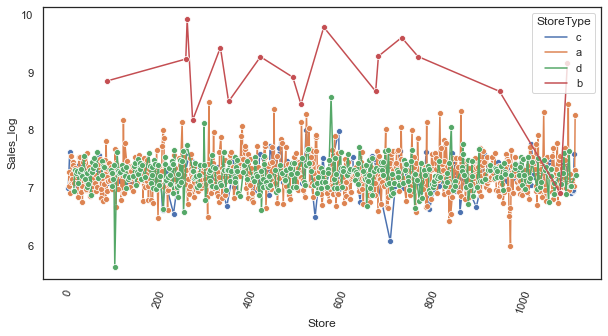

In [36]:
data = train_store_df.groupby('Store').agg({TARGET_COLUMN:'mean','StoreType':'max'})
sns.lineplot(data=data, x='Store', y=TARGET_COLUMN, hue='StoreType', marker='o')
fig = plt.gcf()
style_plot(fig)

,DayOfWeek,DayOfTwoWeeks,DayOfTwoWeeks_fixed_1,DayOfTwoWeeks_fixed_2,Sales_log
DayOfWeek,1.000000,0.495115,0.992354,0.635346,-0.543978
DayOfTwoWeeks,0.495115,1.000000,0.396155,-0.270100,-0.245654
DayOfTwoWeeks_fixed_1,0.992354,0.396155,1.000000,0.704783,-0.551300
DayOfTwoWeeks_fixed_2,0.635346,-0.270100,0.704783,1.000000,-0.526248
Sales_log,-0.543978,-0.245654,-0.551300,-0.526248,1.000000


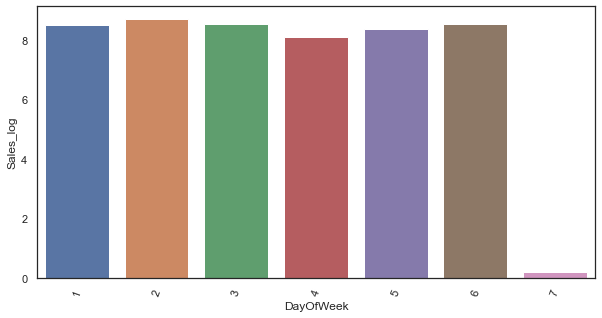

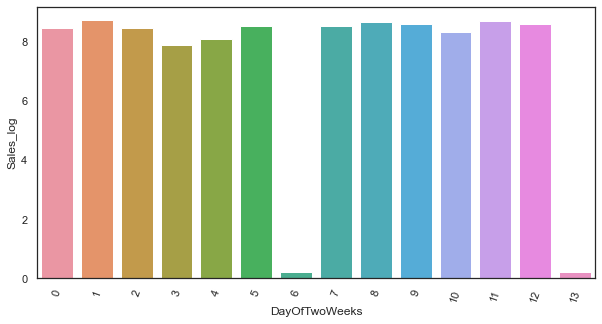

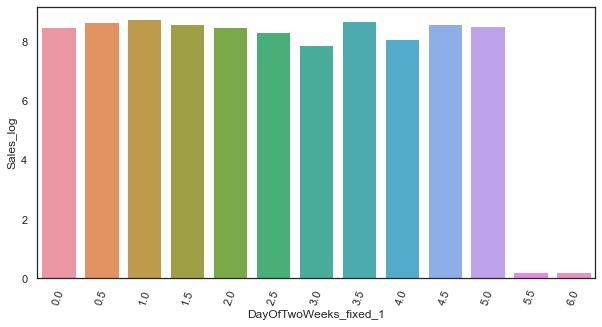

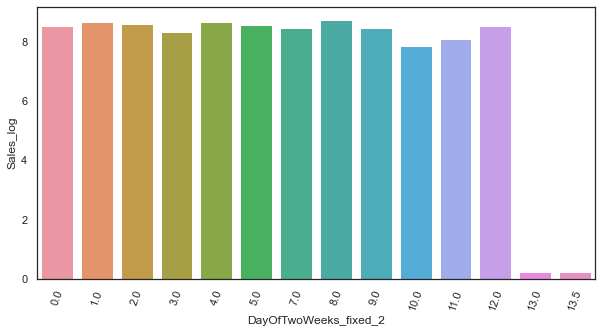

In [37]:
columns = ['DayOfWeek','DayOfTwoWeeks','DayOfTwoWeeks_fixed_1','DayOfTwoWeeks_fixed_2']
display(full_df.loc[full_df['is_train']][columns+[TARGET_COLUMN]].corr())

for x_columns in columns:
    
    data = full_df.loc[full_df['is_train']].groupby(x_columns,as_index=False).agg({TARGET_COLUMN:'mean'})
    sns.barplot(data=data, x=x_columns, y=TARGET_COLUMN)
    fig = plt.gcf()
    style_plot(fig)

<AxesSubplot:>

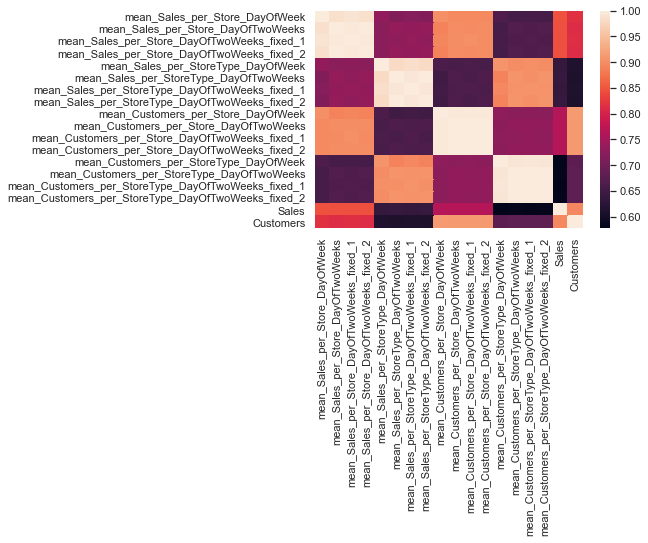

In [38]:
sns.heatmap(full_df[[x for x in full_df.columns if 'mean_' in x] + ['Sales', 'Customers']].corr())

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


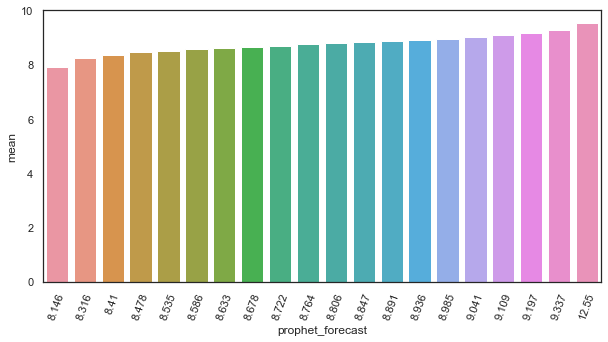

In [39]:
get_bar_plot(df=full_df, 
             column='prophet_forecast', 
             CLASS_LABEL=TARGET_COLUMN)

<a id="regression"></a>
# Modeling
[Back to contents](#contents)

In [62]:
# Split again to train and test datasets
full_df_filtered = full_df.loc[(full_df['is_train']) & (full_df['Open']==1)]
X_train = full_df_filtered.copy()
y_train = full_df_filtered[TARGET_COLUMN].copy()

X_scaled, scaler = prepare_df_for_model(df=X_train.copy(), 
                                        features=features, 
                                        CLASS_LABEL=None, 
                                        toScale=True)

X_scaled_sampled = X_scaled.sample(n=100_000)
y_train_sampled = full_df_filtered.loc[full_df_filtered.index.isin(X_scaled_sampled.index)][TARGET_COLUMN].copy()

In [63]:
allModelsScores = {}

modelsList = [XGBRegressor(), AdaBoostRegressor(), BaggingRegressor(), ExtraTreesRegressor(), 
              GradientBoostingRegressor(), RandomForestRegressor(n_estimators=100), HuberRegressor(), 
              BayesianRidge(), ElasticNet(), LinearRegression(), PassiveAggressiveRegressor(), 
              RANSACRegressor(), SGDRegressor(), KNeighborsRegressor(), RadiusNeighborsRegressor(),
              MLPRegressor(), DecisionTreeRegressor(), ExtraTreeRegressor()]

modelsDict = {type(model).__name__: model for model in modelsList}

for name, reg in tqdm(modelsDict.items()):
    scores = cross_val_score(reg, X_scaled_sampled, y_train_sampled, scoring=rmspe_scorer, cv=3)
    allModelsScores[name] = {'Score': -1*np.mean(scores)}

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
One or more samples have no neighbors within specified radius; predicting NaN.
One or more samples have no neighbors within specified radius; predicting NaN.
One or more samples have no neighbors within specified radius; predicting NaN.


In [64]:
allModelsResultsDf = pd.DataFrame(allModelsScores).T
allModelsResultsDf.sort_values(by='Score',ascending=True)

,Score
HuberRegressor,5.051907e-02
ElasticNet,1.731417e-01
BayesianRidge,1.731697e-01
LinearRegression,1.733461e-01
AdaBoostRegressor,1.736169e-01
GradientBoostingRegressor,1.741723e-01
MLPRegressor,1.826583e-01
XGBRegressor,1.870210e-01
RandomForestRegressor,2.126961e-01
BaggingRegressor,2.417069e-01


In [83]:
bestModelName = allModelsResultsDf.sort_values(by='Score',ascending=True).index[0]
print(f"The best model is: {bestModelName}")
bestModel = modelsDict.get(bestModelName)
bestFit = bestModel.fit(X_scaled, y_train)

The best model is: HuberRegressor


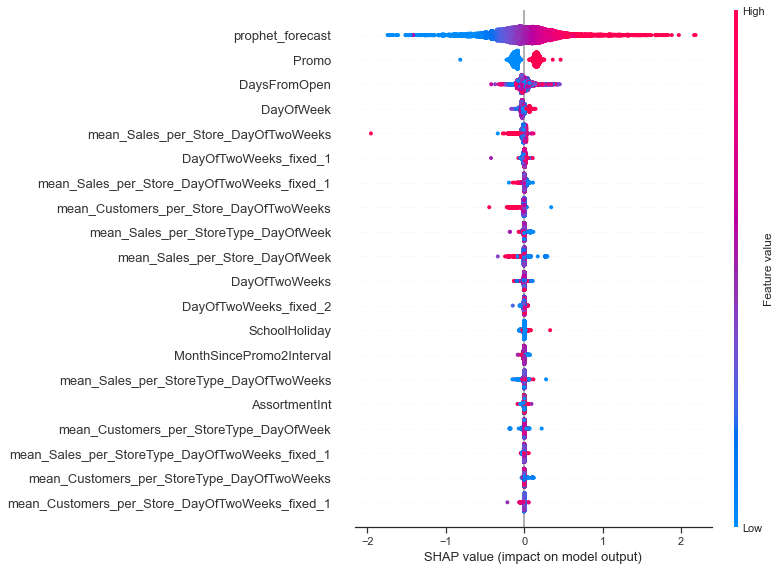

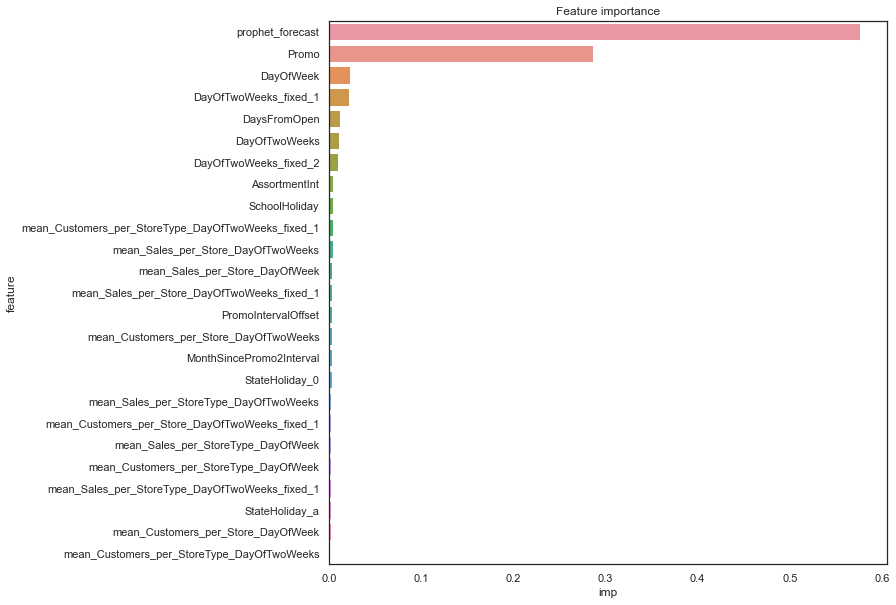

In [79]:
# Since HuberRegressor can't show the shap value, we trained also the XGBRegressor model for the anaysis.
XGBFit = modelsDict.get('XGBRegressor').fit(X_scaled, y_train)

X_scaled_sampled = X_scaled[features].sample(n=10_000)
mybooster, explainer, expected_value, shap_values = get_shap_values(XGBFit, X_scaled_sampled)
get_shap_summary_plot(X_scaled_sampled, explainer, expected_value, shap_values)

if hasattr(bestFit, 'feature_importances_'):
    plot_feature_importance(X_scaled, XGBFit)

<a id="predict"></a>
# Prediction the test and make submission
[Back to contents](#contents)

In [80]:
X_test = full_df.loc[~full_df['is_train']]
X_test_scaled = prepare_df_for_model(df=X_test, 
                                     features=features, 
                                     CLASS_LABEL=None, 
                                     toScale=True, 
                                     scaler=scaler)

In [81]:
y_pred = np.expm1(bestFit.predict(X_test_scaled))
closedIds = set(X_test.loc[X_test['Open']==0]['Id'])
resultsDf = pd.DataFrame({'Id': X_test['Id'], 'Sales': y_pred})
resultsDf['Sales'] = resultsDf.apply(lambda row: 0 if row['Id'] in closedIds else row['Sales'] ,axis=1)
resultsDf['Id'] = resultsDf['Id'].astype(int)
resultsDf.sort_values(by='Id').to_csv(f'submission_{bestModelName}.csv', index=False)